# Objectives : 

* Find time and distance spent during day and during night (done)
* Find time spend idle vs moving (done)
* Find time spent on city road vs highways
* Find turns and turning speeds
* Compare performance of libraries vs raw python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("datasets/go_trackspoints.csv")

In [3]:
df.head()

,id,latitude,longitude,track_id,time
0,1,-10.939341,-37.062742,1,2014-09-13 07:24:32
1,2,-10.939341,-37.062742,1,2014-09-13 07:24:37
2,3,-10.939324,-37.062765,1,2014-09-13 07:24:42
3,4,-10.939211,-37.062843,1,2014-09-13 07:24:47
4,5,-10.938939,-37.062879,1,2014-09-13 07:24:53


## 1. Time/Day analysis

* Time for day : 6am to 7pm
* Time for night : 7pm to 6am

### 1.2 Time spent driving in day vs night

In [4]:
from dateutil import parser
len(df)

18107

In [5]:
trip = 4
trip_filter = df["track_id"] == 1
df_trip = df[0:9000]
df_trip.head()

,id,latitude,longitude,track_id,time
0,1,-10.939341,-37.062742,1,2014-09-13 07:24:32
1,2,-10.939341,-37.062742,1,2014-09-13 07:24:37
2,3,-10.939324,-37.062765,1,2014-09-13 07:24:42
3,4,-10.939211,-37.062843,1,2014-09-13 07:24:47
4,5,-10.938939,-37.062879,1,2014-09-13 07:24:53


In [6]:
# A function which takes datetime object as argument and return if the time was "day" or "night"
def day_night(dt_object):
    
    hour = dt_object.hour
    
    if(hour <= 19 and hour >= 6):
        return "day"
    else:
        return "night"

In [7]:
# Create separate dataframes for day and night data
df_day = pd.DataFrame(columns=["track_id", "latitude", "longitude", "hour"])
df_night = pd.DataFrame(columns=["track_id", "latitude", "longitude", "hour"])

for i in range(len(df_trip)):
    
    time = day_night(parser.parse(df_trip["time"].iloc[i]))
    
    if time == "day":
        hour = (parser.parse(df_trip["time"].iloc[i])).hour
        track_id = df_trip["track_id"].iloc[i]
        lat = df_trip["latitude"].iloc[i]
        long = df_trip["longitude"].iloc[i]
        df_day = df_day.append({"track_id":track_id, "latitude":lat, "longitude":long, "hour":hour}, ignore_index=True)
        
    if time == "night":
        hour = (parser.parse(df_trip["time"].iloc[i])).hour
        track_id = df_trip["track_id"].iloc[i]
        lat = df_trip["latitude"].iloc[i]
        long = df_trip["longitude"].iloc[i]
        df_night = df_night.append({"track_id":track_id, "latitude":lat, "longitude":long, "hour":hour}, ignore_index=True) 

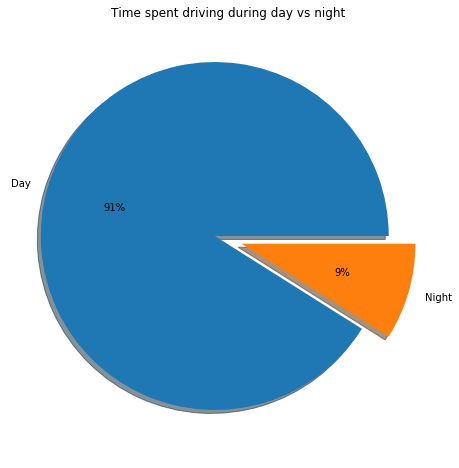

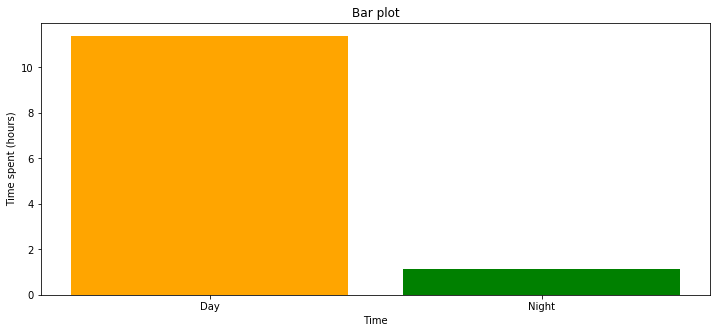

Day driving time :  11.380555555555556  hours
Night driving time :  1.1194444444444445  hours


In [8]:
plt.figure(figsize=(12,8))

plt.title("Time spent driving during day vs night")
plt.pie([len(df_day),len(df_night)], labels = ["Day", "Night"], shadow=True, explode=[0.08, 0.08], autopct="%1.f%%")
plt.show()

plt.figure(figsize=(12,5))
plt.title("Bar plot")
hrs_day = (len(df_day)*5)/3600
hrs_night = (len(df_night)*5)/3600
plt.bar(x=[0,0.6],height=[hrs_day,hrs_night],tick_label=["Day", "Night"], color=("orange","green"), width=0.5)
plt.xlabel("Time")
plt.ylabel("Time spent (hours)")
plt.show()

print("Day driving time : ", hrs_day, " hours")
print("Night driving time : ", hrs_night, " hours")

### 1.2 Distance spent during day vs night

In [9]:
def find_distance(lat1, long1, lat2, long2):
    
    DOF_lat = lat1 - lat2
    DOF_long = long1 - long2
    
    dist_lat = DOF_lat * 111139
    dist_long = DOF_long * 111139
    
    dist = np.sqrt((dist_lat*dist_lat) + (dist_long*dist_long))
    
    return dist

In [10]:
def find_day_night_dist(trip):
    
    df_trip = df[df["track_id"]==trip]
    
    day_dist = 0
    night_dist = 0
    
    for i in range(len(df_trip)-1):
        
        time = parser.parse(df_trip["time"].iloc[i])
        
        lat1 = df_trip["latitude"].iloc[i]
        long1 = df_trip["longitude"].iloc[i]
        lat2 = df_trip["latitude"].iloc[i+1]
        long2 = df_trip["longitude"].iloc[i+1]
        
        if day_night(time) == "day":
            
            dist = find_distance(lat1,long1,lat2,long2)
            day_dist = day_dist + dist
        
        if day_night(time) == "night":
            
            dist = find_distance(lat1,long1,lat2,long2)
            night_dist = night_dist + dist
        
    return (day_dist/1000), (night_dist/1000)

In [11]:
df_distance = pd.DataFrame(columns=["trip", "day distance", "night distance"])
df_trip = df
trips = df_trip["track_id"].unique()



for trip in trips:
    
    day_distance, night_distance = find_day_night_dist(trip)
        
    df_distance = df_distance.append({"trip":trip, "day distance":day_distance, "night distance":night_distance}, ignore_index=True)
    
    

In [12]:
df_distance.head()

,trip,day distance,night distance
0,1.0,2.819207,0.000000
1,2.0,5.566948,0.000000
2,3.0,0.000000,0.879868
3,4.0,0.000000,7.576887
4,8.0,0.455555,0.000000


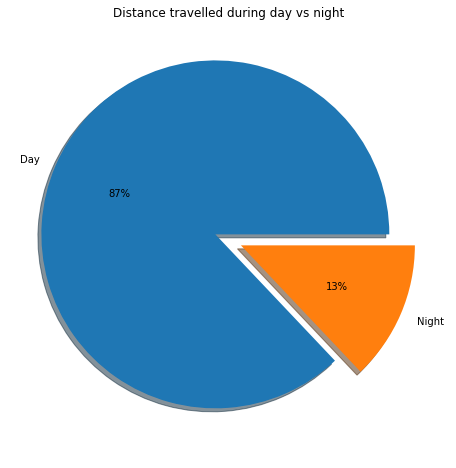

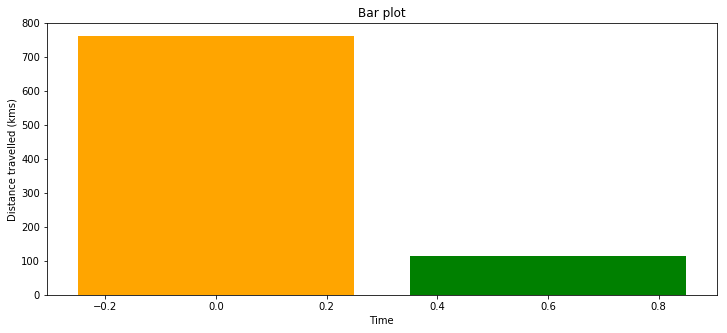

Distance travelled in during day time :  762.5414912294613  kms
Distance travelled in during night time :  113.29298785095139  kms


In [13]:
plt.figure(figsize=(12,8))

plt.title("Distance travelled during day vs night")
plt.pie([df_distance["day distance"].sum(),df_distance["night distance"].sum()], labels = ["Day", "Night"], shadow=True, explode=[0.08, 0.08], autopct="%1.f%%")
plt.show()

plt.figure(figsize=(12,5))
plt.title("Bar plot")
hrs_day = (len(df_day)*5)/3600
hrs_night = (len(df_night)*5)/3600
plt.bar(x=[0,0.6],height=[df_distance["day distance"].sum(),df_distance["night distance"].sum()], color=("orange","green"), width=0.5)
plt.xlabel("Time")
plt.ylabel("Distance travelled (kms)")
plt.show()

print("Distance travelled in during day time : ", df_distance["day distance"].sum(), " kms")
print("Distance travelled in during night time : ", df_distance["night distance"].sum(), " kms")

In [14]:
def find_trip_details(trip):
    trip_filter = df["track_id"] == trip
    df_temp = df[trip_filter]
    
    points_no = len(df_temp)
    total_dist = 0
    
    if(points_no > 1):     #Some values were giving error so had to add this condition
        
        total_dist = 0
        
        for i in range(points_no - 1):
            current_lat = df_temp["latitude"].iloc[i]
            current_long = df_temp["longitude"].iloc[i]
            next_lat = df_temp["latitude"].iloc[i+1]
            next_long = df_temp["longitude"].iloc[i+1]
    
            delta = find_distance(current_lat,current_long,next_lat,next_long)
    
            total_dist = total_dist + delta
        
            total_time = (5 * points_no)
        
            average_speed = ((total_dist/1000) / (total_time/3600))
    
        return total_dist, (total_time/60), average_speed
    
    if(points_no <= 1):
        
        return 0, 0, 0


find_trip_details(49)


(18821.654502569785, 7.083333333333333, 159.4304851982382)

## 2. Idle/moving

In [15]:
def idle_moving(trip):
    
    df_trip = df[df["track_id"]==trip]
    idle_count = 0
    moving_count = 0
    
    for i in range(len(df_trip)-1):
        
        current_lat = df_trip["latitude"].iloc[i]
        current_long = df_trip["longitude"].iloc[i]
        next_lat = df_trip["latitude"].iloc[i+1]
        next_long = df_trip["longitude"].iloc[i+1]
        
        if(current_lat == next_lat and current_long == next_long):
            idle_count = idle_count + 1
            
        else:
            moving_count = moving_count + 1
            
    
    idle_minutes = (idle_count*5)/60
    moving_minutes = (moving_count*5)/60
            
    return idle_minutes, moving_minutes

In [16]:
df_idle_moving = pd.DataFrame(columns=["trip", "idle time", "moving time"])

trips = df["track_id"].unique()

for trip in trips:
    
    idle_mins, moving_mins = idle_moving(trip)
    
    df_idle_moving = df_idle_moving.append({"trip":trip, "idle time":idle_mins, "moving time":moving_mins}, ignore_index=True)

In [17]:
df_idle_moving["idle time"].sum()
df_idle_moving["moving time"].sum()

1398.0833333333335

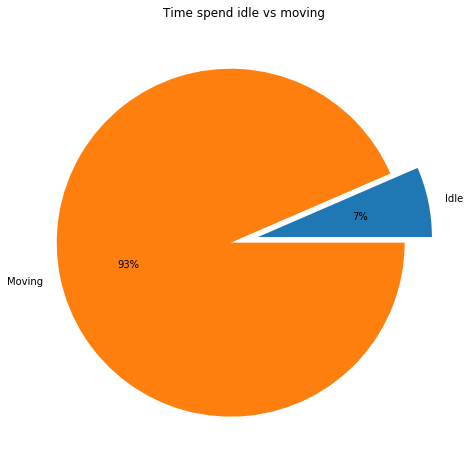

Time spend idle :  1.6208333333333333  hours
Time spend moving :  23.30138888888889 hours


In [18]:
plt.figure(figsize=(8,8))
plt.title("Time spend idle vs moving")
plt.pie([df_idle_moving["idle time"].sum(),df_idle_moving["moving time"].sum()], explode = [0.08, 0.08], autopct="%1.f%%", labels=["Idle", "Moving"])
plt.show()

print("Time spend idle : ", (df_idle_moving["idle time"].sum()/60), " hours")
print("Time spend moving : ", (df_idle_moving["moving time"].sum()/60), "hours")

## 3. Finding turns

Trying to find turns by finding out change in slope of the line

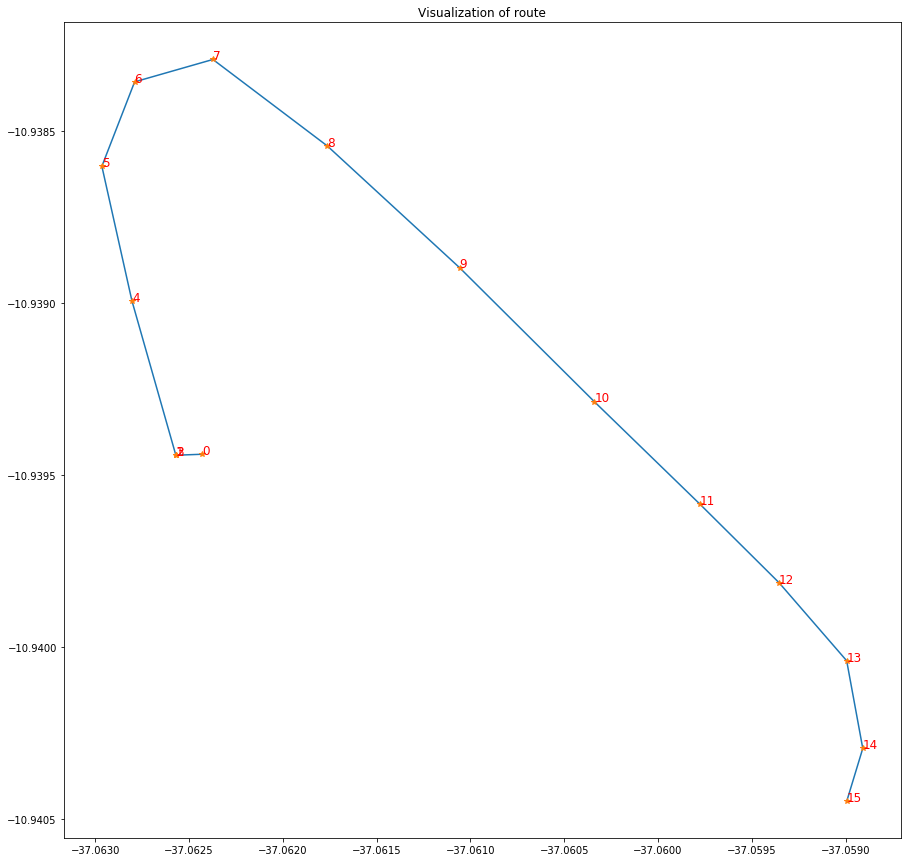

In [19]:
df_trip = df[df["track_id"] == 2]

df_trip = df_trip[0:round(len(df_trip)/7)]

x1 = np.arange(0,len(df_trip))

plt.figure(figsize=(15,15))
plt.title("Visualization of route")
plt.plot(df_trip["longitude"],df_trip["latitude"])
plt.plot(df_trip["longitude"],df_trip["latitude"], "*")
i = 0
for x, y in zip(df_trip["longitude"], df_trip["latitude"]):
    plt.text(x, y, i, color="red", fontsize=12)
    i = i + 1
plt.show()

In [20]:
def slope(x1, y1, x2, y2):
    
    slope = (y2-y1) / (x2-x1)
    
    return slope

len(df_trip)

16

In [21]:
df_slope = pd.DataFrame(columns=["index", "slope", "slope diff"])
cnt = 0

for i in range(len(df_trip)-1) :
    
    slopex = slope(df_trip["longitude"].iloc[i], df_trip["latitude"].iloc[i], df_trip["longitude"].iloc[i+1],df_trip["latitude"].iloc[i+1])
    
    slopeY = slope(df_trip["longitude"].iloc[i-1], df_trip["latitude"].iloc[i-1], df_trip["longitude"].iloc[i],df_trip["latitude"].iloc[i])
    diff = slopex - slopeY
   
    df_slope = df_slope.append({"index":i, "slope":slopex,"slope diff":diff}, ignore_index=True)
    cnt = cnt + 1

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
df_slope

,index,slope,slope diff
0,0.0,0.020501,0.313433
1,1.0,NaN,NaN
2,2.0,NaN,NaN
3,3.0,-1.914729,NaN
4,4.0,-2.438716,-0.523987
5,5.0,1.403948,3.842664
6,6.0,0.155914,-1.248034
7,7.0,-0.411913,-0.567827
8,8.0,-0.501486,-0.089574
9,9.0,-0.541625,-0.040139


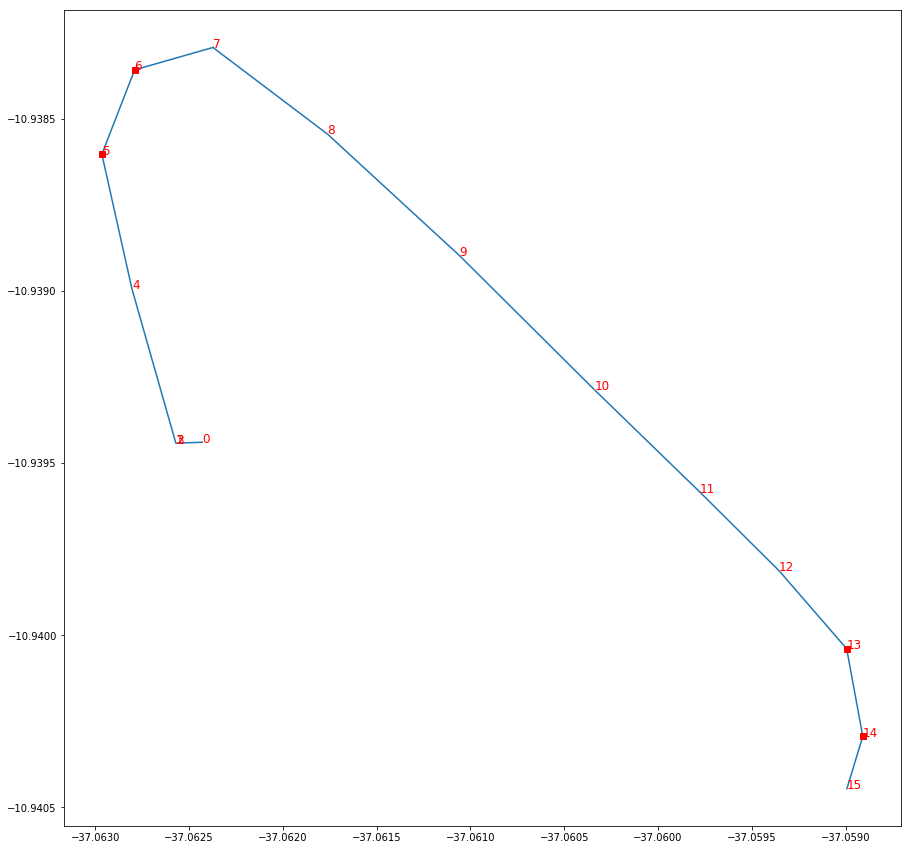

In [23]:
x1 = np.arange(0,len(df_trip))

plt.figure(figsize=(15,15))
plt.plot(df_trip["longitude"],df_trip["latitude"])
plt.plot(df_trip["longitude"],df_trip["latitude"], ",")
i = 0
for x, y in zip(df_trip["longitude"], df_trip["latitude"]):
    plt.text(x, y, i, color="red", fontsize=12)
    
    if(i != 15):
        if(abs(df_slope["slope diff"].iloc[i]) >= 1):
            plt.plot(x,y,"rs")
    i = i + 1
plt.show()

* **Red Square represent the points of turns**
* **Need to imporove the algorithm as point number 7 has not been marked as turn**
* **Need to deal with the missing values in slopes**